# 08.03 - Bootstrap Analysis of Model Uncertainty (Financial Risk)

## Imports and Setup

In [1]:
import pathlib
from datetime import datetime
import math
import sys

import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import seaborn as sns

from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline

sys.path.append("..")

from src.utils.utils import (bound_precision,
                             AnnualTimeSeriesSplit,
                             run_cross_val,
                             RollingAnnualTimeSeriesSplit)
from src.visualization.visualize import (plot_prediction,
                                         plot_joint_plot,
                                         residual_plots,
                                         print_residual_stats,
                                         resids_vs_preds_plot,
                                         seasonal_plot)
from src.features.features import CyclicalToCycle

%matplotlib inline

PROJECT_DIR = pathlib.Path.cwd().parent.resolve()
CLEAN_DATA_DIR = PROJECT_DIR / 'data' / '05-clean'
TEST_RESULTS_PATH = PROJECT_DIR / 'data' / 'results' / 'test_results.csv'


pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import warnings
warnings.filterwarnings('ignore')

## Review Model Performance on Test Data

We have a set of results for 10 years of test data.

This is the closest asessment we have of our performance when we launch the business.

But, there is variation in this data

In [2]:
df = pd.read_csv(TEST_RESULTS_PATH, index_col=0, header=None).rename(columns={1:'bound_precision'})
df.index.rename('year', inplace=True)
df

,bound_precision
year,
2009,0.8
2010,0.6
2011,0.8
2012,1.0
2013,0.8
2014,0.8
2015,0.8
2016,0.8
2017,0.8


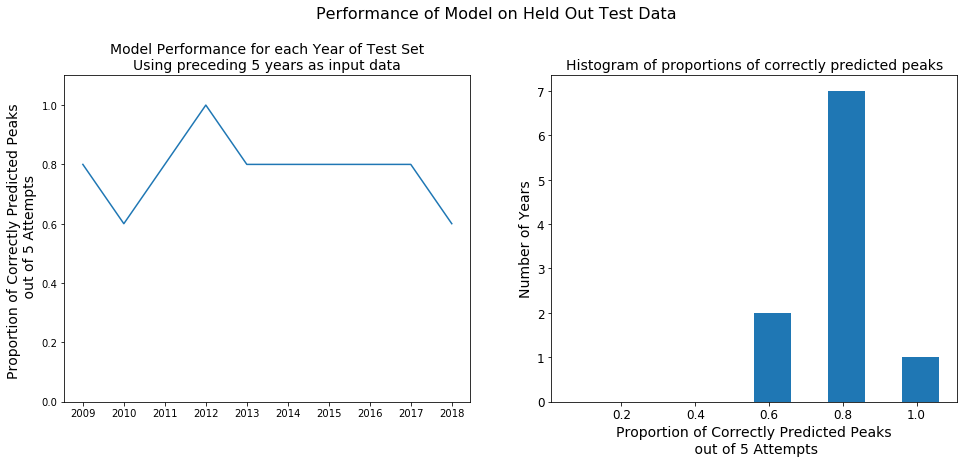

In [3]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
ax1.plot(df)
ax1.set_ylim(0,1.1,0.1)
ax1.set_title('Model Performance for each Year of Test Set\nUsing preceding 5 years as input data', fontsize=14)
ax1.set_ylabel('Proportion of Correctly Predicted Peaks \n out of 5 Attempts', fontsize=14)
ax1.set_xticks(np.arange(min(df.index), max(df.index)+1, 1.0)) 
bins = np.linspace(0, 1.0, 11)+0.01
ax2.hist(df['bound_precision'], bins=bins, align='right', rwidth=1.0)
ax2.set_xlabel('Proportion of Correctly Predicted Peaks\n out of 5 Attempts', fontsize=14)
ax2.set_ylabel('Number of Years', fontsize=14)
ax2.set_title('Histogram of proportions of correctly predicted peaks', fontsize=14)
plt.suptitle('Performance of Model on Held Out Test Data', fontsize=16,  y=1.04)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig(PROJECT_DIR / 'notebooks' / 'saved-images' / 'best-model-performance-on-test-data.PNG', bbox_inches='tight')
plt.show();

## Bootsrap Analysis of Uncertainty

If we want to go forward with a business to sell the prediction service, we should make an asessment of the risk we are taking.

The contract will be written to guarantee a minimum level of performance. If we fail to meet this, we will suffer financial penalties.

Therefore, we should quantify the probabilities of acheiving each performance level.

We can do this by bootstrapping the test results data

This is easier to do than to explain

In [4]:
def get_pooled_data(df, attempts):
    pooled_data = []
    for year in df.index:
        ones = int(df.loc[year, 'bound_precision']*attempts)*[1]
        pooled_data.extend(ones)
        zeros = [0]*(attempts - len(ones))
        pooled_data.extend(zeros)
    return pooled_data

def run_sim(n_trials, pooled_data, attempts=5):
    yearly_proportions = []
    for n_trial in range(n_trials):
        sim_year_results = np.random.choice(pooled_data,size=attempts, replace=True)
        yearly_proportion = sum(sim_year_results)/attempts
        yearly_proportions.append(yearly_proportion)
    return sorted(yearly_proportions)

In [5]:
attempts=5
n_trials=1000000
pooled_data = get_pooled_data(df, attempts)
yp = run_sim(n_trials, pooled_data, attempts) 

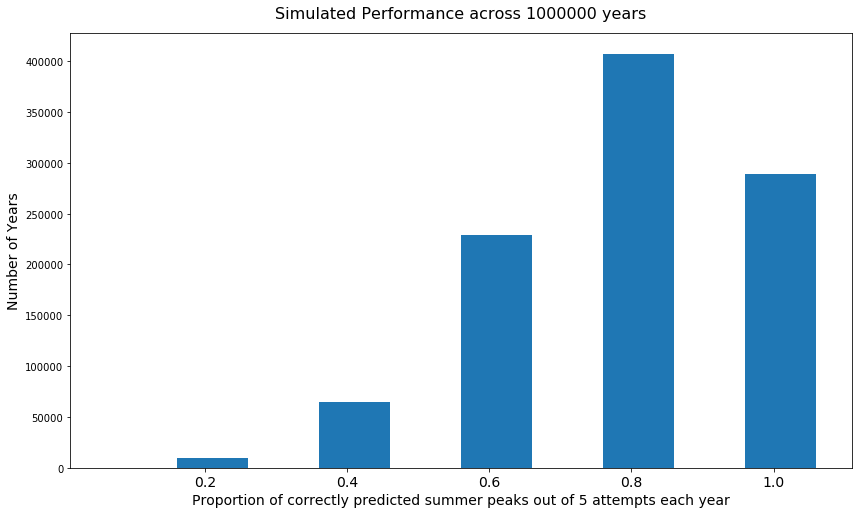

In [6]:
fig, ax = plt.subplots(figsize=(14,8))
bins = np.linspace(0, 1.0, 11)+0.01
ax.hist(yp, bins=bins, align='right', rwidth=1.0, density=False)
ax.set_xlabel('Proportion of correctly predicted summer peaks out of 5 attempts each year', fontsize=14)
ax.set_ylabel('Number of Years', fontsize=14)
ax.set_title(f'Simulated Performance across {n_trials} years', fontsize=16,  y=1.02)
plt.xticks(fontsize=14)
plt.savefig(PROJECT_DIR / 'notebooks' / 'saved-images' / 'bootstrap-results-years.PNG')
plt.show();

In [7]:
counts = pd.Series(yp).value_counts().sort_index()
freqs = (counts/n_trials)*100
print('Probability of occurrence of each score shown as a percentage')
print(freqs)

Probability of occurrence of each score shown as a percentage
0.0     0.0541
0.2     0.9166
0.4     6.4929
0.6    22.9340
0.8    40.7260
1.0    28.8764
dtype: float64


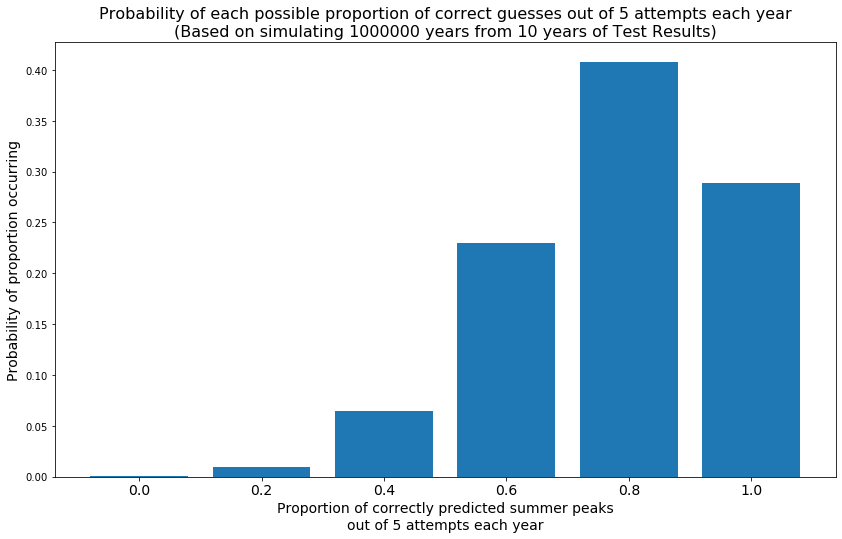

In [8]:
x = [str(val) for val in freqs.index]
x_pos = [i for i,_ in enumerate(x)]
heights = freqs.values/100

fig, ax = plt.subplots(figsize=(14,8))
ax.bar(x_pos, heights)
plt.xticks(x_pos, x)
ax.set_xlabel('Proportion of correctly predicted summer peaks\nout of 5 attempts each year', fontsize=14)
ax.set_ylabel('Probability of proportion occurring', fontsize=14)
title_str = f'Probability of each possible proportion of correct guesses out of {attempts} attempts each year\n'
title_str += f'(Based on simulating {n_trials} years from 10 years of Test Results)'
plt.xticks(fontsize=14)
ax.set_title(title_str, fontsize=16)
plt.savefig(PROJECT_DIR / 'notebooks' / 'saved-images' / 'bootstrap-results-histogram.PNG', bbox_inches='tight')
plt.show();

This helps us understand the risk we are taking when we say we can predict at least x% of the 5 summer peaks

This can then be worked into the appropriate financial scenarios